HACKDAY CDS - TIME 1

# PROJECT SOLUTION PLANNING

A mobilidade tem um papel fundamental no dia a dia da população de qualquer país, e no Brasil, o cenário não é diferente. Novas formas de abordar o tema têm se popularizado cada vez mais nos últimos anos, como o aumento de práticas de aluguel de veículos, e a busca dos consumidores por locações de veículos por assinatura.

Segundo a Associação Brasileira das Locadoras de Automóveis (ABLA), o faturamento bruto do segmento, que tem no Brasil 13.903 locadoras ativas, deu um salto de 33,5% no ano de 2021, e chegou ao recorde de R$ 23,5 bilhões.¹

Ainda segundo a mesma matéria da ABLA, em 2021, as locadoras compraram 441.858 carros zero quilômetro, equivalentes a 25,5% de todos os automóveis emplacados no ano. Houve portanto um crescimento de 22,5% em relação às compras feitas em 2020 (360.567 unidades).

Junto ao aumento da frota de veículos, aumenta também a necessidade de um incremento na venda dos seminovos por parte das locadoras. Isto garante a viabilidade do negócio, visto que:

Aumenta o poder de barganha na aquisição de novos veículos junto as montadoras.
Evita custos de manutenção cada vez mais altos, em decorrência do desgaste dos veículos ao longo do tempo.
Mantém a frota atualizada com relação as novas tecnologias presentes nos novos veículos.
Reforça uma postura sustentável da empresa, com veículos projetados cada vez mais com foco na sustentabilidade.
Este desafio aborda o case da locadora Mobility Cars, tradicional player do segmento de locação de veículos, presente em todo o território brasileiro.

A empresa está com dificuldades de atingir as metas de vendas de seminovos, e por isso vem amargurando quedas nos seus resultados. Ela precisa com urgência voltar a vender mais, para poder seguir renovando a sua frota, mantendo assim sua competitividade diante da concorrência.

A empresa utiliza hoje como referência de valores de veículos a tabela FIPE², amplamente difundida no mercado nacional. Porém, é comum esta referência não ser assertiva para definir o valor real praticado pelo mercado, a depender da marca e modelo do veículo.

O objetivo desta competição é desenvolver um modelo de regressão, que com base no histórico de valores de venda de veículos praticados em todo o Brasil, seja capaz de construir uma tabela de referência de preços condizente com a realidade do mercado brasileiro.

A diretoria comercial da Mobility Cars, está convicta de que a nova tabela de referência será a peça chave para reverter o quadro negativo atual. Com ela, a empresa voltará a atingir as metas de vendas de seminovos estipuladas, retomando sua posição de destaque no mercado.

Materiais & Referências:

1 - ABLA- Estatísticas do aluguel de veículos em 2021
2 - Tabela FIPE

## Input

1. Business problem
    - A empresa está com dificuldades de atingir as metas de vendas de seminovos, e por isso vem amargurando quedas nos seus resultados. Ela precisa com urgência voltar a vender mais, para poder seguir renovando a sua frota, mantendo assim sua competitividade diante da concorrência.
    
2. Datasets:

    - **treino.csv**
    - **teste.csv**


## Output


- Desenvolver um modelo de regressão, que com base no histórico de valores de venda de veículos praticados em todo o Brasil, seja capaz de construir uma tabela de referência de preços condizente com a realidade do mercado brasileiro.

1. Deliverables:

- Model's performance and results report with the following topics:
    - Preço por ID

## Tasks

**Project Development Method**

The project was developed based on the CRISP-DS (Cross-Industry Standard Process - Data Science, a.k.a. CRISP-DM) project management method, with the following steps:

- Project Planning
- Business Understanding;
- Data Collection;
- Data Cleaning;
- Exploratory Data Analysis (EDA);
- Data Preparation;
- Machine Learning Modelling and fine-tuning;
- Model and Business performance evaluation / Results;
- Model deployment.


<img src="https://www.researchgate.net/profile/Youssef-Tounsi-2/publication/341627969/figure/fig1/AS:903550875996160@1592434724532/CRISP-DM-data-mining-framework.png" alt="some text" width=500 height=400 align="left">


# Imports

In [29]:
import math
import pandas                as pd
import numpy                 as np
import seaborn               as sns
import matplotlib.pyplot     as plt
import datetime
import inflection
import warnings
import random
import pickle
import json

import xgboost               as xgb
import lightgbm              as lgbm
    
from pandas.api.types        import is_string_dtype, is_numeric_dtype
from matplotlib              import gridspec
from scipy                   import stats as ss
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.model_selection import RandomizedSearchCV
from boruta                  import BorutaPy

from IPython.core.display    import HTML
from IPython.display         import Image

# Versão da Linguagem Python
from platform                import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())
warnings.filterwarnings( 'ignore' )

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.2


## Helper Functions

In [30]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values # Confusion Matrix
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_absolute_percentage_error( y, yhat ):
    y, yhat = np.array(y), np.array(yhat)
    return np.mean( np.abs( ( y-yhat ) / y ))

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

# Define the function to evaluate the models
def weighted_mean_absolute_error(df, y, yhat):
    weights = df.is_holiday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(y-yhat))/(np.sum(weights)), 2)

def ml_error( df,model_name, y, yhat):
    mae = mean_absolute_error( y,yhat )
    mape = mean_absolute_percentage_error( y,yhat )
    rmse = np.sqrt(mean_squared_error( y,yhat ))
    WMAE = weighted_mean_absolute_error(df, y, yhat)
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'RMSE': rmse,
                          'WMAE': WMAE}, index=[0])

# time-series cross validation implementation
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    WMAE_list = []
     
    for k in reversed( range( 1, kfold+1 ) ): #k-fold implementation
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        start_date_validation = x_training['date'].max() - datetime.timedelta( weeks=k*22) #primeira semanada da venda realizada
        end_date_validation = x_training['date'].max() - datetime.timedelta( weeks=(k-1)*22) #ultima semana

        # filtering dataset
        training = x_training[x_training['date'] < start_date_validation]
        validation = x_training[(x_training['date'] >= start_date_validation) & (x_training['date'] <= end_date_validation)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'weekly_sales'], axis=1 ) 
        ytraining = training['weekly_sales']

        # validation
        xvalidation = validation.drop( ['date', 'weekly_sales'], axis=1 )
        yvalidation = validation['weekly_sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error( xvalidation, model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        rmse_list.append( m_result['RMSE'] )
        WMAE_list.append( m_result['WMAE'])

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV':  np.round( np.mean( mae_list ), 2 ).astype( str )  + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ),
                          'WMAE CV': np.round( np.mean( WMAE_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( WMAE_list ), 2 ).astype( str )}, index=[0] )


In [31]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# LOADING DATA

In [14]:
#project home path for importing files
home_path = '/home/marxcerqueira/repos/hackday-cds-time1/'

#loading datasets available for this project
df_treino              = pd.read_csv(home_path + 'data/treino.csv', low_memory = False)
df_teste               = pd.read_csv(home_path + 'data/teste.csv', low_memory = False)
df_sample_submission   = pd.read_csv(home_path + 'data/sample_submission.csv', low_memory = False)


In [15]:
#first look at the dataframes
df_treino.head()

,ID,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,tipo_anuncio,entrega_delivery,troca,elegivel_revisao,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,attr_veiculo_alienado,preco
0,105869496634249611881157692933406072990,8.0,VOLKSWAGEN,AMAROK,2.0 TRENDLINE 4X4 CD 16V TURBO INTERCOOLER DIE...,2017,2017.0,55672.0,Automática,4,Picape,N,Preto,PF,São Paulo,São Paulo (SP),Pessoa Física,False,False,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,IPVA pago,Licenciado,NaN,Todas as revisões feitas pela agenda do carro,NaN,123231.992782
1,14165644411757892901957277406025007093,8.0,JAGUAR,F-PACE,2.0 16V TURBO DIESEL PRESTIGE AWD 4P AUTOMÁTICO,2017,2017.0,47858.0,Automática,4,Utilitário esportivo,N,Branco,PF,Rio de Janeiro,Rio Grande do Sul (RS),Pessoa Física,False,False,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,IPVA pago,NaN,NaN,Todas as revisões feitas pela agenda do carro,NaN,272076.023576
2,78515656948521351316652580664682810356,14.0,CHEVROLET,CRUZE,1.8 LT 16V FLEX 4P AUTOMÁTICO,2012,2013.0,122323.0,Automática,4,Sedã,N,Prata,PJ,Rio de Janeiro,São Paulo (SP),Loja,True,True,False,Aceita troca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53411.539492
3,36797041166808090517929207429817328298,8.0,PORSCHE,718,2.0 16V H4 GASOLINA BOXSTER PDK,2020,2021.0,14207.0,Automática,2,Picape,N,Branco,PF,São Paulo,São Paulo (SP),Pessoa Física,False,False,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,NaN,NaN,NaN,NaN,NaN,299697.071937
4,338618517701891995317200439137014723900,8.0,VOLVO,XC90,2.0 INSCRIPTION TURBO GASOLINA 4P 4X4 AUTOMÁTICO,2015,2016.0,43760.0,Automática,4,Utilitário esportivo,N,Preto,PF,Ribeirão Preto,São Paulo (SP),Pessoa Física,False,False,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,NaN,NaN,NaN,Todas as revisões feitas pela agenda do carro,NaN,255164.344178


In [16]:
#first look at the dataframes
df_teste.head()

,ID,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,tipo_anuncio,entrega_delivery,troca,elegivel_revisao,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,attr_veiculo_alienado
0,24813264385557040124808779273028388499,14.0,CHEVROLET,SPIN,1.8 LTZ 8V FLEX 4P AUTOMÁTICO,2017,2017.0,62969.0,Automática,4,Sedã,N,Branco,PJ,Recife,Santa Catarina (SC),Loja,False,False,False,Aceita troca,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,295636316453795508942188530111300065666,8.0,FIAT,TORO,1.8 16V EVO FLEX FREEDOM AT6,2021,2021.0,26324.0,Automática,4,Picape,N,Branco,PF,São Paulo,São Paulo (SP),Pessoa Física,False,False,False,Aceita troca,NaN,NaN,IPVA pago,Licenciado,NaN,NaN,NaN
2,101258309166227950735244624080888109884,8.0,VOLKSWAGEN,POLO,1.0 200 TSI HIGHLINE AUTOMÁTICO,2019,2020.0,37002.0,Automática,4,Hatchback,N,Branco,PF,São Paulo,São Paulo (SP),Pessoa Física,False,False,False,NaN,Único dono,Todas as revisões feitas pela concessionária,IPVA pago,Licenciado,Garantia de fábrica,Todas as revisões feitas pela agenda do carro,NaN
3,28348734455782469411126661985772047409,15.0,CHEVROLET,TRACKER,1.8 MPFI LTZ 4X2 16V FLEX 4P AUTOMÁTICO,2012,2015.0,86762.0,Automática,4,Sedã,N,Branco,PJ,Rio de Janeiro,Rio de Janeiro (RJ),Loja,False,False,False,Aceita troca,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,193163160502972147671913739170248305797,8.0,BMW,120i,2.0 16V SPORT ACTIVEFLEX 4P AUTOMÁTICO,2015,2017.0,93040.0,Automática,4,Sedã,N,Branco,PF,Campo Grande,Rio Grande do Sul (RS),Pessoa Física,False,False,False,NaN,NaN,NaN,IPVA pago,Licenciado,NaN,NaN,NaN


In [20]:
df_sample_submission.head()

,ID,preco
0,24813264385557040124808779273028388499,134829.562524
1,295636316453795508942188530111300065666,185573.018383
2,101258309166227950735244624080888109884,115475.455269
3,28348734455782469411126661985772047409,214619.215264
4,193163160502972147671913739170248305797,143094.784514


# DATA DISCRIPTION

In [32]:
#Copy dataset
df1 = df_treino.copy()

## Rename Columns

In [33]:
# checking columns
df1.columns

Index(['ID', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado', 'preco'],
      dtype='object')

In [19]:
columns = ['ID', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao','ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado','cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor','tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao','attr_veiculo_aceita_troca', 'attr_veiculo_único_dono','attr_veiculo_todas_as_revisões_feitas_pela_concessionária','attr_veiculo_ipva_pago', 'attr_veiculo_licenciado','attr_veiculo_garantia_de_fábrica','attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro','attr_veiculo_alienado', 'preco']

## Data Dimension

In [34]:
# checking data dimesions to see if we have enough computational power
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 39446
Number of Cols: 29


## Data Types

In [35]:
# checking features dtypes
df1.dtypes

ID                                                             object
num_fotos                                                     float64
marca                                                          object
modelo                                                         object
versao                                                         object
ano_de_fabricacao                                               int64
ano_modelo                                                    float64
odometro                                                      float64
cambio                                                         object
num_portas                                                      int64
tipo                                                           object
blindado                                                       object
cor                                                            object
tipo_vendedor                                                  object
cidade_vendedor     

## Check NA Values

In [36]:
# checking NA values sum and its percentagem from total number of rows
missing_count = df1.isnull().sum() # the count of missing values
value_count = df1.isnull().count() # the count of all values

missing_percentage = round(missing_count/value_count *100, 2) # the percentage of missing values
missing_df = pd.DataFrame({'missing values count': missing_count, 'percentage': missing_percentage})
missing_df

,missing values count,percentage
ID,0,0.00
num_fotos,237,0.60
marca,0,0.00
modelo,0,0.00
versao,0,0.00
ano_de_fabricacao,0,0.00
ano_modelo,0,0.00
odometro,0,0.00
cambio,0,0.00
num_portas,0,0.00


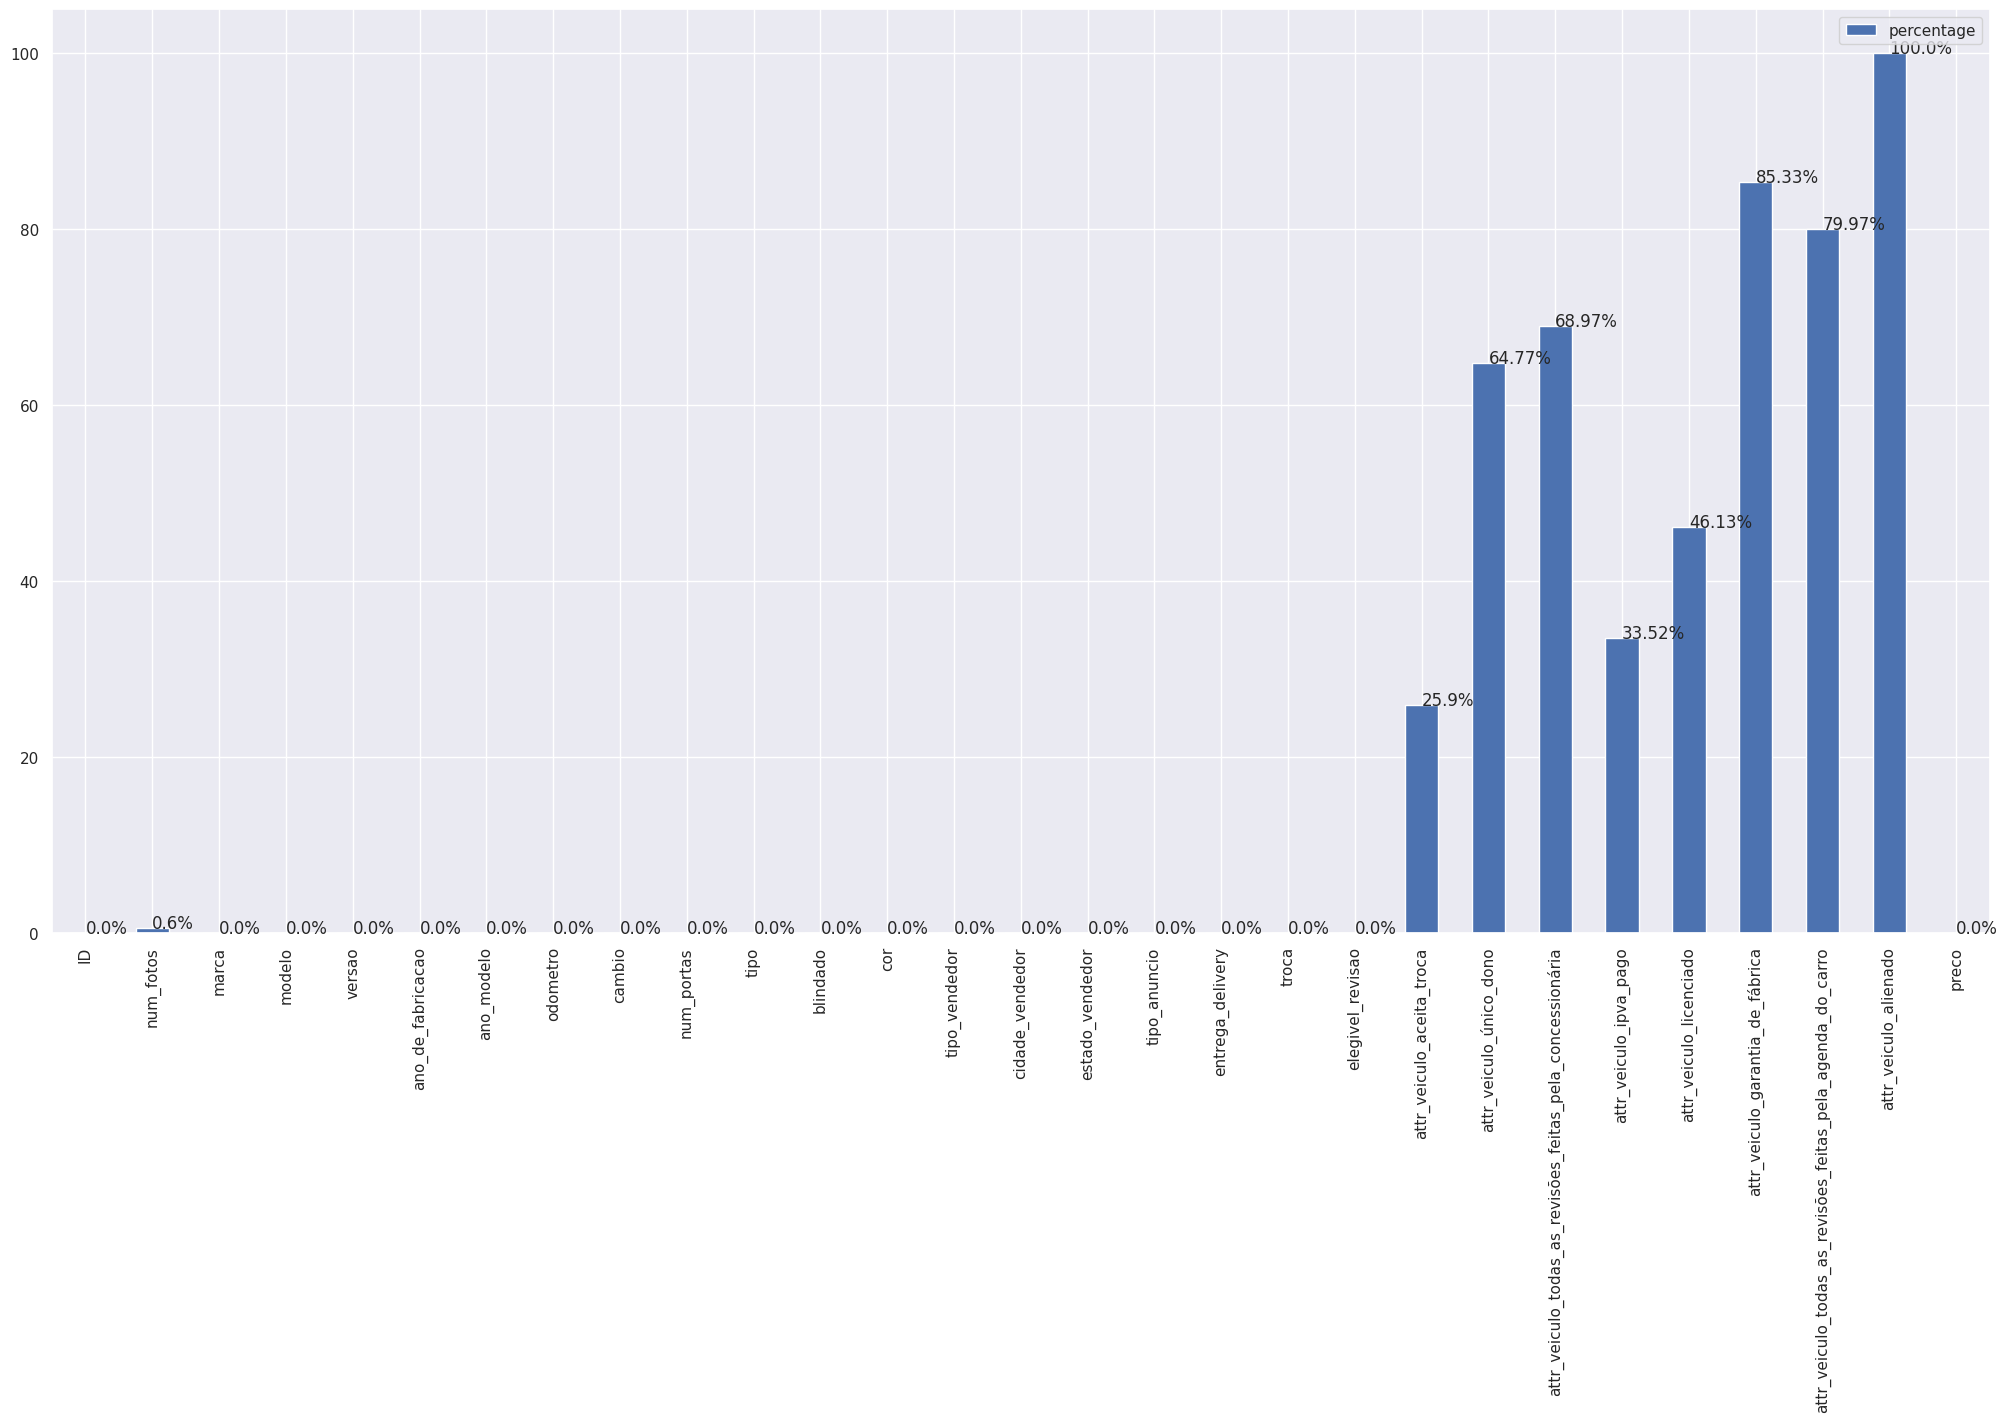

In [37]:
# missing na chart
barchart = missing_df.plot.bar(y='percentage')
for index, percentage in enumerate( missing_percentage ):
    barchart.text( index, percentage, str(percentage)+'%')

## Fillout NA

## Change Types

In [38]:
df1.dtypes # checking datatypes transformation

ID                                                             object
num_fotos                                                     float64
marca                                                          object
modelo                                                         object
versao                                                         object
ano_de_fabricacao                                               int64
ano_modelo                                                    float64
odometro                                                      float64
cambio                                                         object
num_portas                                                      int64
tipo                                                           object
blindado                                                       object
cor                                                            object
tipo_vendedor                                                  object
cidade_vendedor     

## Descriptive Statistics

In [ ]:
# separate numerical and categorical attributes
num_attributes = df1.select_dtypes( include = 'number')
cate_attributes = df1.select_dtypes( include = 'object')

### Numerical Attributes

In [ ]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m1 = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m1

In [ ]:
# check numerical features distribution
num_attributes.hist(bins = 50);

### Categorical Attributes

In [ ]:
# check unique values of categorical features
cate_attributes.apply( lambda x: x.unique().shape[0])

# FEATURE ENGINEERING

## Hypothesis Mindmap

## Creating Hypothesis

## Final Hypothesis List

## Feature Engineering

# VARIABLE FILTERING

## Line Filtering

## Columns Selection

# EXPLORATORY DATA ANALYSIS (EDA)

## Univariate Analysis

### Response Variable

### Numerical Variable

### Categorical Variable

## Bivariate Analysis

## Multivariate Analysis

# DATA PREPARATION

## Feature Normalization

## Feature Rescaling

## Feature Transformation

### Enconding

### Target Variable Transformation

### Nature Transformation

# FEATURE SELECTION

## Spliting dataframe into training and test dataset

## Feature Selector (boruta?)

## Best Features

# MACHINE LEARNING ALGORITHM MODELS

## Modelo 1

## Modelo 2

## Modelo 3

## Compare Model's Performance

# HYPERPARAMETERS FINE TUNING

# ERROR INTERPRETATION

# MODEL DEPLOYMENT